## 第三章 神经网络
1. 从感知机到神经网络  
2. 激活函数  
3. 多维数组的运算  
4. 三层神经网络的实现  
5. 输出层的设计  
6. 手写数字识别  
7. 小结  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from dataset.mnist import load_mnist

### 3.1 从感知机到神经网络
- 神经网络的一个重要性质是它可以自动地从数据中学习到合适的权重参数。
- 复习感知机: 感知机接收 x1 和 x2 两个输入信号，输出 y
$$ y = \begin{cases} 0 & (b + w_1x_1 + w_2x_2 \le 0) \\ 1 & (b + w_1x_1 + w_2x_2 \gt 0) \end{cases}$$
$$y = h(b + w_1x_1 + w_2x_2) , h(x) = \begin{cases} 0 & (x \le 0) \\ 1 & (x \gt 0) \end{cases} $$
- 激活函数是连接感知机和神经网络的桥梁。
- 感知机中使用了阶跃函数作为激活函数。
- 如果将激活函数从阶跃函数换成其他函数，就可以进入神经网络的世界了。

### 3.2 激活函数
- **函数**就是给定某个输入后，会返回某个输出的转换器.  
- 激活函数必须使用**非线性**函数（y=cx这种的不行）.
- 激活函数的"**平滑性**"(比如sigmoid，处处可导)对神经网络的学习具有重要意义:
    - 数学可行性：支持梯度下降和反向传播
    - 信息丰富性：保留输入信号的相对强度
    - 训练稳定性：提供连续的优化路径
    - 收敛保证性：避免陷入梯度为0的平台区 

#### 3.2.2 阶跃函数的实现

In [2]:
# 单个数
def step_func(x):
    if x > 0:
        return 1
    else:
        return 0

In [3]:
print(step_func(0.5))
print(step_func(-2))

1
0


In [4]:
# 多个数的np数组
def step(x):
    return (x > 0).astype(int)

In [5]:
x = np.array([-1, 0, 1, 2])
step(x)

array([0, 0, 1, 1])

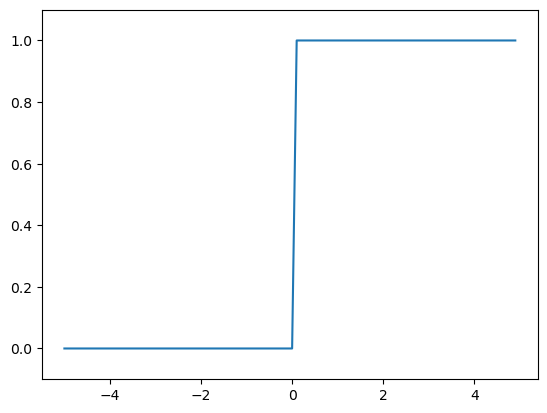

In [6]:
x = np.arange(-5.0, 5.0, 0.1)
y = step(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.show()

#### 3.2.4 Sigmoid 函数的实现
$$ h(x) = \frac{1}{1 + exp(-x)}$$

In [7]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

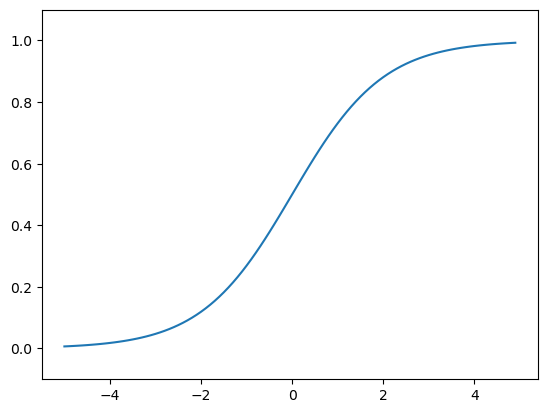

In [8]:
x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.show()

#### 3.2.5 Tanh 函数的实现
$$ tanh(x) = \frac{e^x - e^-x}{e^x + e^-x} $$
$$ tahn(x) = 2 \cdot sigmoid(2x) - 1 $$
- tanh 本质上就是“被拉伸后的 sigmoid”。
- 形状：S 形曲线（跟 sigmoid 类似，但更“高大上”）
    - 输出范围：(-1 , 1)
    - 中心在 0（这是最大的差别）
    - 强烈的压缩性（输入大时饱和，梯度趋近 0）
- 可以简单想象成：
    - sigmoid：把输入压缩到 (0,1)
    - tanh：把输入压缩到 (-1,1)
    - 图像整体比 sigmoid 更陡、更对称。
- 优点：
    1. 输出围绕 0 对称（zero-centered）这是大优势。
       - sigmoid 的输出是 0～1，意味着所有输出都是“正数”，
       - 导致下一层的输入分布偏一边，容易造成梯度更新偏移。
       - 而 tanh 输出有负有正，更符合自然信号分布：梯度下降更稳定更快
    2. 梯度比 sigmoid 更大一些（在非饱和区）
        - 对小输入：sigmoid 的梯度最大 ~ 0.25
        - tanh 的梯度最大 ~ 1
        - → 学习更快
    3. 非线性强，表达能力较好：比 sigmoid 的“S”更陡，变化更迅速，非线性更强。
- tanh 通常在什么时候使用：
    - RNN（尤其是早期的 LSTM / GRU）- 因为 RNN 的输入需要被压成合理范围，tanh 的输出 (-1,1) 正好适合循环更新的结构。
    - 网络比较浅（1-3 层）时 - 深度不大时梯度消失不明显，tanh 的 zero-centered 性质更有优势。
    - 输入数据是负的 + 正的混合时，比 sigmoid 更自然。

In [9]:
def _tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


def tanh(x):
    return 2 * sigmoid(2*x) - 1

In [10]:
x = np.array([-4, -0.5, 0, 0.5, 4])
print(sigmoid(x))
print(tanh(x))

[0.01798621 0.37754067 0.5        0.62245933 0.98201379]
[-0.9993293  -0.46211716  0.          0.46211716  0.9993293 ]


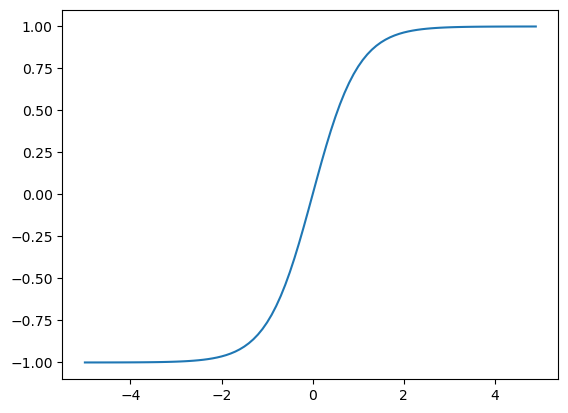

In [11]:
x = np.arange(-5.0, 5.0, 0.1)
y = tanh(x)
plt.plot(x, y)
plt.ylim(-1.1, 1.1)
plt.show()

#### 3.2.7 ReLU 函数的实现
$$ h(x) = \begin{cases} x & (x \gt 0) \\ 0 & (x \le 0) \end{cases}$$

In [12]:
# ReLU function
def relu(x):
    return np.maximum(0, x)

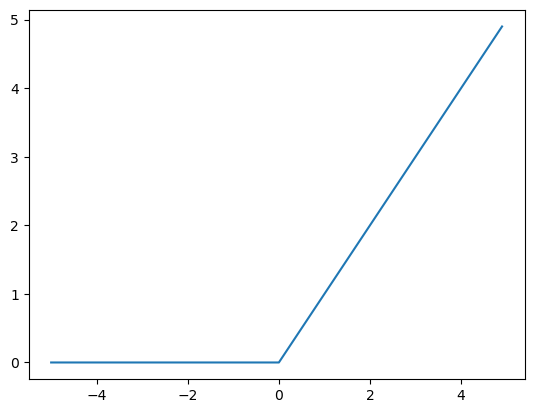

In [13]:
x = np.arange(-5, 5, 0.1)
y = relu(x)
plt.plot(x, y)
plt.show()

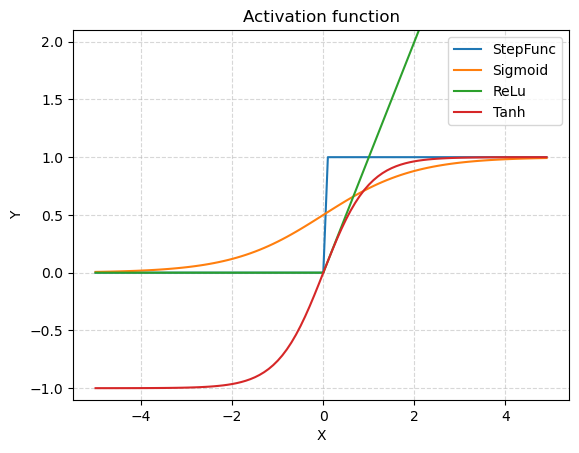

In [14]:
# 比较三条线
x = np.arange(-5, 5, 0.1)
y1, y2, y3, y4 = step(x), sigmoid(x), relu(x), tanh(x)

plt.plot(x, y1, label='StepFunc')
plt.plot(x, y2, label='Sigmoid')
plt.plot(x, y3, label='ReLu')
plt.plot(x, y4, label='Tanh')
plt.ylim(-1.1, 2.1)
plt.title('Activation function')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### 3.3 多维数组的运算

In [15]:
x = np.array([[1,2], [3,4], [5,6]])
print(x)
print(np.ndim(x))
print(x.shape)
print(x.size)

[[1 2]
 [3 4]
 [5 6]]
2
(3, 2)
6


In [16]:
A = np.array([[1,2], [3,4]])
B = np.array([[5,6], [7,8]])
print(A*B)
print(np.dot(A, B))

[[ 5 12]
 [21 32]]
[[19 22]
 [43 50]]


In [17]:
C = np.array([[1,2,3], [4,5,6]])
D = np.array([[1,2], [3,4], [5,6]])
np.dot(C, D)    # 2, 3 * 3, 2 = 2, 2

array([[22, 28],
       [49, 64]])

In [18]:
E = np.array([[1], [2], [3], [4]])
F = np.array([[1,2,3,4]])
print(E.shape)
print(F.shape)

(4, 1)
(1, 4)


In [19]:
print(E)
print(F)
print(np.dot(E, F))

[[1]
 [2]
 [3]
 [4]]
[[1 2 3 4]]
[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]]


In [20]:
X = np.array([1, 2])    # 两个输入神经元
W = np.array([[1, 3, 5], [2, 4, 6]])    # 权重
print(X.shape)
print(W.shape)

(2,)
(2, 3)


In [21]:
np.dot(X, W)    # 1*1+2*2=5, 1*3+2*4=11, 1*5+2*6=17

array([ 5, 11, 17])

### 3.4 三层神经网络的实现

#### 3.4.2 分层: 各层间信号传递的实现

In [22]:
# 第0层 （输入层）
X = np.array([1.0, 0.5])

In [23]:
# 第1层 （隐藏层）
W1 = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
B1 = np.array([0.1, 0.2, 0.3])

A1 = np.dot(X, W1) + B1 # 加权输入 / 加权总和
Z1 = sigmoid(A1) # 激活函数
print(A1)
print(Z1)

[0.3 0.7 1.1]
[0.57444252 0.66818777 0.75026011]


In [24]:
# 第2层 （隐藏层）
W2 = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
B2 = np.array([0.1, 0.2])

A2 = np.dot(Z1, W2) + B2
Z2 = sigmoid(A2)
print(A2)
print(Z2)

[0.51615984 1.21402696]
[0.62624937 0.7710107 ]


In [25]:
# 第3层 （输出层）
W3 = np.array([[0.1, 0.3], [0.2, 0.4]])
B3 = np.array([0.1, 0.2])

A3 = np.dot(Z2, W3) + B3

def identity_function(x):
    return x

Y = identity_function(A3)
print(A3)
print(Y)

[0.31682708 0.69627909]
[0.31682708 0.69627909]


#### 3.4.3 汇总：一次实现多层

In [26]:
def init_network():
    network = {}
    network['W1'] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network['b1'] = np.array([0.1, 0.2, 0.3])
    network['W2'] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network['b2'] = np.array([0.1, 0.2])
    network['W3'] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network['b3'] = np.array([0.1, 0.2])
    
    return network

def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = identity_function(a3)

    return y

network = init_network()
x = np.array([1.0, 0.5])
y = forward(network, x)
print(y)

[0.31682708 0.69627909]


In [27]:
Y == y    # 分层实现 与 汇总实现 两次结果一样

array([ True,  True])

### 3.5 输出层的设计 (Softmax)
$$y_k = \frac{exp(a_k)}{\sum\limits_{i=1}^n exp(a_i)}$$
- softmax 函数的分子是输入信号 $a_k$ 的指数函数，分母是所有输入信号的指数函数的和。所以，输出层的各个神经元都受到所有输入信号的影响。  
- softmax 函数的输出是 0.0 到 1.0 之间的实数, softmax函数的输出值的总和是 1, 可以把 softmax 函数的输出解释为“概率”。
- 即便使用了 softmax 函数，各个元素之间的大小关系也不会改变。这是因为指数函数（ y = exp(x) ）是单调递增函数。
- 基于上一条，神经网络只把输出值最大的神经元所对应的类别作为识别结果，并且，即便使用 softmax 函数，输出值最大的神经元的位置也不会变。
- 神经网络在进行分类时，输出层的 softmax 函数可以省略。在实际的问题中，由于指数函数的运算需要一定的计算机运算量，因此输出层的 softmax 函数一般会被省略。

In [28]:
a = np.array([0.3, 2.9, 4.0])
exp_a = np.exp(a)
print(exp_a)

[ 1.34985881 18.17414537 54.59815003]


In [29]:
sum_exp_a = np.sum(exp_a)
print(sum_exp_a)

74.1221542101633


In [30]:
y = exp_a / sum_exp_a
print(y)

[0.01821127 0.24519181 0.73659691]


In [31]:
# Softmax 的实现 (有缺陷，就是溢出. 如果a=1000的话，e的1000次幂会返回无穷大的数)
def softmax(a):
    exp_a = np.exp(a)
    return exp_a / np.sum(exp_a)

print(softmax(a))

[0.01821127 0.24519181 0.73659691]


In [32]:
c = np.max(a)
a - c

array([-3.7, -1.1,  0. ])

In [33]:
exp_a = np.exp(a-c)
exp_a

array([0.02472353, 0.33287108, 1.        ])

In [34]:
y = exp_a / np.sum(exp_a)
y

array([0.01821127, 0.24519181, 0.73659691])

In [35]:
# Softmax 的改进，通过减去最大值
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    return exp_a / np.sum(exp_a)

softmax(a)

array([0.01821127, 0.24519181, 0.73659691])

### 3.6 手写数字识别

#### 3.6.1 MNIST 数据集

In [36]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [37]:
# 显示训练图像的第一张
from PIL import Image

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)
img = x_train[0]
label = t_train[0]

print(label)        # 5
print(img.shape)    # (784,)
img = img.reshape(28, 28)  # 把图像的形状变成原来的尺寸
print(img.shape)    # (28, 28)

# img_show(img)    # 会打开第三方应用查看图片

5
(784,)
(28, 28)


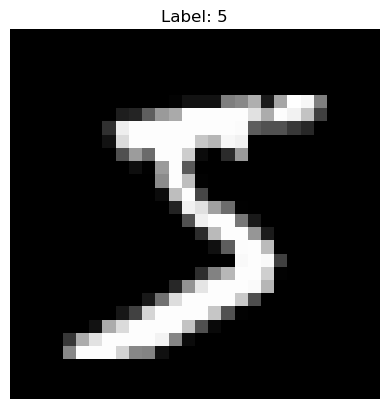

标签: 5
图像形状: (28, 28)


In [38]:
# Plot第一张图像
img = x_train[0].reshape(28, 28)
label = t_train[0]

plt.imshow(img, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')  # 不显示坐标轴
plt.show()

print(f"标签: {label}")
print(f"图像形状: {img.shape}")

#### 3.6.2 神经网络的推理处理

In [39]:
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    with open('dataset/sample_weight.pkl', 'rb') as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)    # 这里softmax只能处理一条数据
    return y

In [40]:
# 利用测试数据预测准确度
x, t = get_data()
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])   # 这里的x[i]是10000条测试数据中的一条
    pos = np.argmax(y)
    if pos == t[i]:
        accuracy_cnt += 1

print(f'Accuracy: {accuracy_cnt / len(x):.2%}')

Accuracy: 93.52%


#### 3.6.3 批处理 (一次性计算大型数组要比分开逐步计算各个小型数组速度更快)
- 批处理对计算机的运算大有利处，可以大幅缩短每张图像的处理时间;
- 这是因为大多数处理数值计算的库都进行了能够高效处理大型数组运算的最优化;
- 并且，在神经网络的运算中，当数据传送成为瓶颈时，批处理可以减轻数据总线的负荷。

In [41]:
# 查看测试数据x 和神经网络参数的信息
print(x.shape)
print(network['W1'].shape)
print(network['W2'].shape)
print(network['W3'].shape)
print(network['b1'].shape)
print(network['b2'].shape)
print(network['b3'].shape)

(10000, 784)
(784, 50)
(50, 100)
(100, 10)
(50,)
(100,)
(10,)


In [42]:
# 查看神经网络预测第一条测试数据的输出结果，以及对应的标签信息
y = predict(network, x[0])
print(y)
print(np.max(y))
print(np.argmax(y))
print(t[0])

[8.4412408e-05 2.6350631e-06 7.1549317e-04 1.2586251e-03 1.1727932e-06
 4.4990808e-05 1.6269318e-08 9.9706501e-01 9.3744620e-06 8.1831042e-04]
0.997065
7
7


In [43]:
# 创建示例矩阵
A = np.random.rand(3, 4)  # 3x4矩阵
B = np.random.rand(4, 5)  # 4x5矩阵

print("矩阵A形状:", A.shape)
print("矩阵B形状:", B.shape)

# 矩阵乘法
C = np.dot(A, B)  # 或者 A @ B
print("乘积结果形状:", C.shape)  # 输出: (3, 5)
C

矩阵A形状: (3, 4)
矩阵B形状: (4, 5)
乘积结果形状: (3, 5)


array([[1.24976397, 1.06259157, 1.58076407, 1.20426243, 1.38961774],
       [0.96264536, 0.82758289, 1.3170265 , 0.95847509, 1.00410374],
       [0.84608241, 0.74302448, 0.81746136, 0.57152082, 0.91981749]])

In [44]:
# 理解axis=0 和 1的不同处理方式
# axis=0 按行操作，比较不同行里 相同列的数据 - 跨样本操作
# axis=1 按列操作，比较同一行里 不同列的数据 - 单个样本内部操作
x = np.array([[0.1, 0.8, 0.1], [0.3, 0.1, 0.6], [0.2, 0.5, 0.3], [0.8, 0.1, 0.1]])
print(x.ndim)
print(x.shape)
print(np.max(x, axis=0))
print(np.max(x, axis=1))
print(np.argmax(x, axis=0))
print(np.argmax(x, axis=1))
print(np.sum(x))
print(np.sum(x, axis=0))
print(np.sum(x, axis=1))

2
(4, 3)
[0.8 0.8 0.6]
[0.8 0.6 0.5 0.8]
[3 0 1]
[1 2 1 0]
4.0
[1.4 1.5 1.1]
[1. 1. 1. 1.]


In [45]:
# 理解Numpy数组比较方式
y = np.array([1, 2, 1, 0])
t = np.array([1, 2, 0, 0])
print(y==t)
np.sum(y==t)

[ True  True False  True]


np.int64(3)

In [46]:
# 利用测试数据预测准确度
x, t = get_data()
network = init_network()

batch_size = 100
accuracy_cnt = 0
for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    pos = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(pos == t[i:i+batch_size])

print(f'Accuracy: {accuracy_cnt / len(x):.2%}')

Accuracy: 93.52%


In [47]:
# Softmax 的终极写法，可以处理各种形状的输入数据，无论多少维度
def softmax(x):
    """
    keepdims=True 保持维度结构，确保广播正确
    x = np.array([[1, 2, 3], [4, 5, 6]]) # 形状: (2,3)
    np.max(x, axis=-1)                   # 形状: (2,)  ← 无法广播 [3, 6] 
    np.max(x, axis=-1, keepdims=True)    # 形状: (2,1) ← 完美广播 [[3], [6]] 
    """
    x -= np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

### 3.7 小结
本章介绍了神经网络的前向传播。本章介绍的神经网络和上一章的感知机在信号的按层传递这一点上是相同的，但是，向下一个神经元发送信号时，改变信号的激活函数有很大差异。神经网络中使用的是平滑变化的 sigmoid函数，而感知机中使用的是信号急剧变化的阶跃函数。这个差异对于神经网络的学习非常重要，我们将在下一章介绍。
- 神经网络中的激活函数使用平滑变化的 sigmoid 函数或 ReLU 函数。
- 通过巧妙地使用 NumPy 多维数组，可以高效地实现神经网络。
- 机器学习的问题大体上可以分为回归问题和分类问题。
- 关于输出层的激活函数，回归问题中一般用恒等函数，分类问题中一般用 softmax 函数。
- 分类问题中，输出层的神经元的数量设置为要分类的类别数。
- 输入数据的集合称为批。通过以批为单位进行推理处理，能够实现高速的运算。